Install necessary packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import yfinance as yf
from prophet import Prophet

In [2]:
pip install yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --------------------------- ------------ 2.1/3.0 MB 13.0 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 13.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 14.8 MB/s eta 0:00:00
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl (435 kB)
  Created wheel for peewee

In [3]:
!pip install yfinance

In [4]:
!pip install prophet

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -------- ------------------------------- 2.9/13.3 MB 18.7 MB/s eta 0:00:01
   ---------------- ----------------------- 5.5/13.3 MB 15.3 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.3 MB 14.5 MB/s eta 0:00:01
   --------------------------------- ------ 11.3/13.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 13.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/991.0 kB ? eta -:--:--
   --------------------------------------- 991.0/991.0 kB 15.5 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ------------- -------------------------- 2/6 [importlib_resources]
   -------------------- ------------------- 3/6 [holidays]
   -------------------- ------------------- 3/6 [holidays]
   -------------------- ------------------- 3/6 [holidays]
   -------------------- ----

Create synthetic Store Sales data

In [7]:
np.random.seed(42)

dates = pd.date_range(start="2023-01-01", end="2023-06-30", freq="D")
num_days = len(dates)
num_stores = 5

data_list = []

for store in range(1, num_stores + 1):
    base_sales = 200 + store * 20
    trend = np.linspace(0, 50, num_days)  # upward trend
    seasonality = 20 * np.sin(np.arange(num_days) * 2 * np.pi / 30)  # monthly seasonality
    noise = np.random.normal(0, 10, num_days)
    promotions = np.random.choice([0, 1], size=num_days, p=[0.7, 0.3])
    sales = base_sales + trend + seasonality + noise + promotions * 30  # promotions boost sales
    
    store_df = pd.DataFrame({
        "date": dates,
        "store": store,
        "promotions": promotions,
        "sales": sales
    })
    data_list.append(store_df)

df = pd.concat(data_list).reset_index(drop=True)

Data Preprocessing & Feature Engineering

In [9]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract date features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Sort values for lag features
df = df.sort_values(['store', 'date'])

# Create lag features (lag_1, lag_7)
df['lag_1'] = df.groupby('store')['sales'].shift(1)
df['lag_7'] = df.groupby('store')['sales'].shift(7)

# Drop initial rows with NaN lag values
df = df.dropna()

# Features and target
features = ['promotions', 'store', 'day_of_week', 'month', 'lag_1', 'lag_7']
target = 'sales'

X = df[features]
y = df[target]

# Feature scaling (only on numeric lag features)
scaler = StandardScaler()
X.loc[:, ['lag_1', 'lag_7']] = scaler.fit_transform(X[['lag_1', 'lag_7']])

# One-hot encode 'store', 'day_of_week', 'month' if you want better performance (optional)
X = pd.get_dummies(X, columns=['store', 'day_of_week', 'month'], drop_first=True)

# Train test split (time series split by date)
# We'll split by last 20 days for test set
split_date = df['date'].max() - pd.Timedelta(days=20)
X_train = X[df['date'] <= split_date]
y_train = y[df['date'] <= split_date]
X_test = X[df['date'] > split_date]
y_test = y[df['date'] > split_date]

Model Training

In [10]:
# Individual models
rf = RandomForestRegressor(random_state=42, n_estimators=100)
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100)

rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)

# Predictions for individual models
pred_rf = rf.predict(X_test)
pred_gbr = gbr.predict(X_test)

# Evaluate
print("RandomForest RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("GradientBoosting RMSE:", np.sqrt(mean_squared_error(y_test, pred_gbr)))

RandomForest RMSE: 19.030943456311935
GradientBoosting RMSE: 20.91728091899256


Ensembling

In [13]:
# ✅ Updated code
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

bagging = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=50), n_estimators=10, random_state=42)
bagging.fit(X_train, y_train)
pred_bagging = bagging.predict(X_test)
print("Bagging Regressor RMSE:", np.sqrt(mean_squared_error(y_test, pred_bagging)))

# Voting Regressor combining rf and gbr
voting = VotingRegressor([('rf', rf), ('gbr', gbr)])
voting.fit(X_train, y_train)
pred_voting = voting.predict(X_test)
print("Voting Regressor RMSE:", np.sqrt(mean_squared_error(y_test, pred_voting)))


Bagging Regressor RMSE: 17.050775150633832
Voting Regressor RMSE: 19.06691213292754


Plot actual vs predicted (voting regressor)

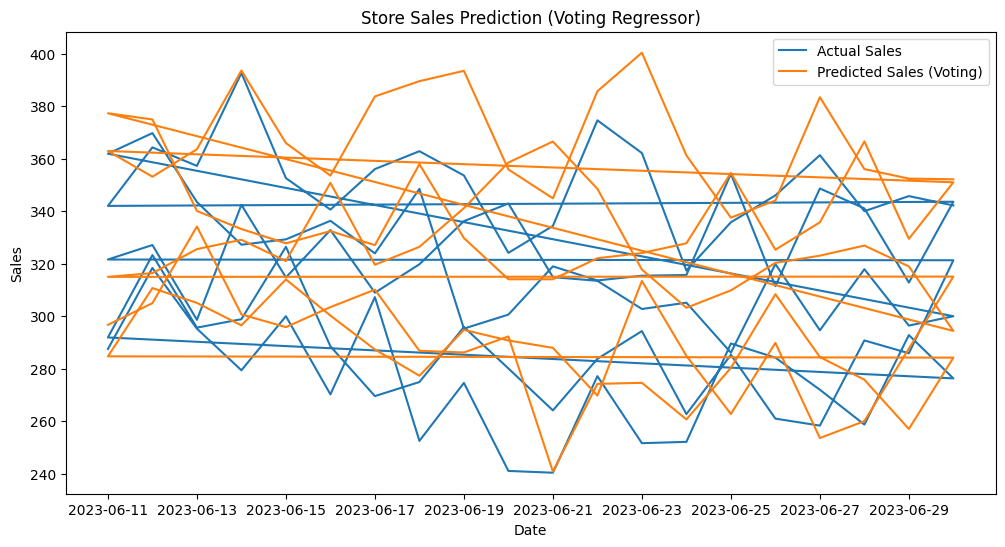

In [14]:
plt.figure(figsize=(12,6))
plt.plot(df['date'][df['date'] > split_date], y_test, label='Actual Sales')
plt.plot(df['date'][df['date'] > split_date], pred_voting, label='Predicted Sales (Voting)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Store Sales Prediction (Voting Regressor)')
plt.legend()
plt.show()